### (4) Get the data

*Once every previous step is completed, we want to collect the data that we think could be useful to build our model. We will use the following datasets from different sources :*

    - Medical Appointment No Show, SOURCE : https://www.kaggle.com/datasets/joniarroba/noshowappointments {1}

In [150]:
# Importing libraries
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Option to display all the columns of a dataframe
pd.set_option('display.max_columns', None)

# Creating a function that returns the path of a dataset
def get_file_path(subdirectory, filename):
    file_path = os.path.join(os.getcwd(), subdirectory, filename)
    return file_path

# Calling the get_file_path function to extract the {1} csv file and opening it
file_path = get_file_path("Datasets","noshowappointments.csv")
appointments = pd.read_csv(f"{file_path}")

### (5) Take a quick glance at the data structure

*Let’s take a look at the metadata that defines the selected datasets.*

In [151]:
# Outputing the head() method, to take a quick glance a what the data looks like
appointments.head(5)

# Outputing the info() method, to get a quick description of the data
appointments.info()

# Outputing the describe() method, to get a summary of numerical variables
appointments.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


### (6) Create a test set

It may sound strange to voluntarily set aside part of the data at this stage, but we want to minimize the **data snooping** bias. Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large). Using **stratified sampling** : the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

*Since we know that variables such as age, gender, insurance, diagnosis, distance, weekday, visit time, lead time, and previous no-show appeared in at least half of the studies. We will want to have a test set that is stratified accordingly to those variables.*

*We spend quite a bit of time on test set generation for a good reason: this is an often neglected but critical part of a Machine Learning project.*

In [152]:
from sklearn.model_selection import StratifiedShuffleSplit

# Creating a stratified split train/test set, to ensure that we have enough no-shows in our test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(appointments, appointments["No-show"]):
        strat_train_set = appointments.loc[train_index]
        strat_test_set = appointments.loc[test_index]

### (7) Discover and Visualize the Data to gain insight

*So far we have only taken a quick glance at the data to get a general understanding of the kind of data you are manipulating. Now the goal is to go a little bit more in depth. Hopefully the previous sections gave us an idea of a few ways we can explore the data and gain insights.*

In [153]:
# Creating a copy of the train set to ensure that we don't harm the original set
train_set_copy = strat_train_set.copy()

In [154]:
# Convert the datetime column to a pandas datetime object
train_set_copy['ScheduledDay'] = pd.to_datetime(train_set_copy['ScheduledDay'], format='%Y-%m-%dT%H:%M:%SZ')
train_set_copy['AppointmentDay'] = pd.to_datetime(train_set_copy['AppointmentDay'], format='%Y-%m-%dT%H:%M:%SZ')

# Experimenting with new attributes

train_set_copy['TimeOfSchedule'] = train_set_copy['ScheduledDay'].dt.time
train_set_copy['DateOfSchedule'] = train_set_copy['ScheduledDay'].dt.date

# Convert DateOfSchedule to Timestamp object
train_set_copy['DateOfSchedule'] = pd.to_datetime(train_set_copy['DateOfSchedule'])

# Difference in number of days between the DateOfSchedule and the AppointmentDay
train_set_copy['LeadTime'] = (train_set_copy['AppointmentDay'] - train_set_copy['DateOfSchedule']).dt.days

# What day of the week was the due appointment - AppointmentDay (Monday=0 and Sunday=6)
train_set_copy['AppointmentDay'] = pd.to_datetime(train_set_copy['AppointmentDay'])
train_set_copy['WeekdayOfApp'] = train_set_copy['AppointmentDay'].dt.weekday

# What month was the due appointment - AppointmentDay
train_set_copy['MonthOfApp'] = train_set_copy['AppointmentDay'].dt.month
train_set_copy['DayOfApp'] = train_set_copy['AppointmentDay'].dt.day

# Scheduled date
train_set_copy['WeekdayOfSchedule'] = train_set_copy['ScheduledDay'].dt.weekday
train_set_copy['HourOfSchedule'] = train_set_copy['ScheduledDay'].dt.hour
train_set_copy['TimeOfDaySchedule'] = train_set_copy['HourOfSchedule'].apply(
    lambda x: 'Morning' if 11 >= x >= 5 else 'Afternoon' if 16 >= x >= 12 else 'Evening' if 20 >= x >= 17 else 'Night'
)

train_set_copy

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,TimeOfSchedule,DateOfSchedule,LeadTime,WeekdayOfApp,MonthOfApp,DayOfApp,WeekdayOfSchedule,HourOfSchedule,TimeOfDaySchedule
66371,6.412451e+13,5512415,F,2016-03-28 08:51:28,2016-05-25,44,JARDIM CAMBURI,0,0,0,0,0,1,No,08:51:28,2016-03-28,58,2,5,25,0,8,Morning
70034,3.978166e+14,5697118,F,2016-05-13 14:58:32,2016-05-13,44,SÃO PEDRO,0,0,0,0,0,0,No,14:58:32,2016-05-13,0,4,5,13,4,14,Afternoon
101064,5.784260e+13,5627010,F,2016-04-27 08:55:45,2016-06-07,37,SANTA MARTHA,0,0,0,0,0,1,No,08:55:45,2016-04-27,41,1,6,7,2,8,Morning
39143,7.226743e+12,5690663,F,2016-05-12 10:27:00,2016-05-13,51,HORTO,0,0,0,0,0,0,No,10:27:00,2016-05-12,1,4,5,13,3,10,Morning
89538,8.191354e+12,5769072,F,2016-06-03 08:21:28,2016-06-03,58,NOVA PALESTINA,0,1,0,0,0,0,No,08:21:28,2016-06-03,0,4,6,3,4,8,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97764,3.866211e+14,5764160,M,2016-06-02 09:54:28,2016-06-02,48,MÁRIO CYPRESTE,0,0,0,0,0,0,No,09:54:28,2016-06-02,0,3,6,2,3,9,Morning
81021,3.958823e+13,5638275,M,2016-04-29 07:52:18,2016-05-03,58,CARATOÍRA,0,1,0,0,0,0,No,07:52:18,2016-04-29,4,1,5,3,4,7,Morning
41308,9.491228e+13,5670766,F,2016-05-06 14:36:28,2016-05-06,0,ANTÔNIO HONÓRIO,0,0,0,0,0,0,No,14:36:28,2016-05-06,0,4,5,6,4,14,Afternoon
6473,8.365278e+14,5636679,M,2016-04-28 15:51:21,2016-05-02,76,SANTO ANTÔNIO,0,0,0,0,0,1,Yes,15:51:21,2016-04-28,4,0,5,2,3,15,Afternoon


In [155]:
# Experimenting with a new variable for previous no-shows

train_set_copy.sort_values(by=['AppointmentDay','PatientId'],inplace=True)
train_set_copy['PatientId'] = train_set_copy['PatientId'].astype(int)

# Converting no-shows to numerical variable
train_set_copy['No-show'] = train_set_copy['No-show'].replace({'Yes': 1, 'No': 0})

# Calculate previous no-shows
train_set_copy['Past_No_shows'] = train_set_copy.groupby('PatientId')['No-show'].cumsum()
train_set_copy['Past_No_shows'] = train_set_copy['Past_No_shows'] - train_set_copy['No-show']

train_set_copy

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,TimeOfSchedule,DateOfSchedule,LeadTime,WeekdayOfApp,MonthOfApp,DayOfApp,WeekdayOfSchedule,HourOfSchedule,TimeOfDaySchedule,Past_No_shows
1792,253866521,5563137,M,2016-04-08 15:13:35,2016-04-29,53,BENTO FERREIRA,0,1,0,0,0,1,0,15:13:35,2016-04-08,21,4,4,29,4,15,Afternoon,0
706,318385314,5559991,F,2016-04-08 08:22:02,2016-04-29,31,JESUS DE NAZARETH,0,0,0,0,0,1,0,08:22:02,2016-04-08,21,4,4,29,4,8,Morning,0
1831,422861257,5638450,F,2016-04-29 08:02:33,2016-04-29,30,CRUZAMENTO,1,0,0,0,0,0,0,08:02:33,2016-04-29,0,4,4,29,4,8,Morning,0
463,522886422,5633872,F,2016-04-28 09:58:32,2016-04-29,66,SÃO CRISTÓVÃO,0,1,1,0,0,0,1,09:58:32,2016-04-28,1,4,4,29,3,9,Morning,0
117,744463183,5539219,F,2016-04-01 14:27:30,2016-04-29,34,SANTO ANTÔNIO,1,0,0,0,0,1,0,14:27:30,2016-04-01,28,4,4,29,4,14,Afternoon,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107940,995167783577869,5769563,F,2016-06-03 08:58:25,2016-06-08,6,PRAIA DO CANTO,0,0,0,0,0,1,0,08:58:25,2016-06-03,5,2,6,8,4,8,Morning,0
93937,995196886477797,5777420,F,2016-06-06 13:45:49,2016-06-08,38,JARDIM DA PENHA,0,0,0,0,0,0,0,13:45:49,2016-06-06,2,2,6,8,0,13,Afternoon,0
89974,998191338231254,5786052,F,2016-06-08 07:58:49,2016-06-08,4,SANTOS REIS,0,0,0,0,0,0,0,07:58:49,2016-06-08,0,2,6,8,2,7,Morning,0
108643,998488365413733,5736934,F,2016-05-25 08:56:09,2016-06-08,49,BELA VISTA,0,0,0,0,0,1,0,08:56:09,2016-05-25,14,2,6,8,2,8,Morning,0


In [156]:
# Creating a function to measure the prevalence of a variable in respect to our dependent variable
def calc_prevalence(y):
 return sum(y), len(y), (sum(y)/len(y))

# Testing variables for their prevalence 
train_set_copy.groupby('WeekdayOfApp').apply(lambda x: calc_prevalence(x['No-show'].values))
train_set_copy.groupby('MonthOfApp').apply(lambda x: calc_prevalence(x['No-show'].values))
train_set_copy.groupby('DayOfApp').apply(lambda x: calc_prevalence(x['No-show'].values))
train_set_copy.groupby('TimeOfDaySchedule').apply(lambda x: calc_prevalence(x['No-show'].values))
train_set_copy.groupby('LeadTime').apply(lambda x: calc_prevalence(x['No-show'].values))

LeadTime
-6                             (1, 1, 1.0)
-1                             (4, 4, 1.0)
 0      (1470, 30952, 0.04749289222021194)
 1          (918, 4209, 0.218104062722737)
 2       (1274, 5359, 0.23773091994775145)
                       ...                
 155                         (5, 8, 0.625)
 162                          (2, 10, 0.2)
 169           (1, 6, 0.16666666666666666)
 176           (3, 11, 0.2727272727272727)
 179           (1, 7, 0.14285714285714285)
Length: 130, dtype: object

In [157]:
# Calculating the prevalence of No-shows in the training set (same distribution as the whole dataset)
calc_prevalence(train_set_copy['No-show'])

(17855, 88421, 0.20193166781646893)

### (8) Prepare the Data for Machine Learning Algorithms

*It’s time to prepare the data for your Machine Learning algorithms. Instead of just doing this manually, you should write functions to do that, for several good reasons:*

• This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).

• You will gradually build a library of transformation functions that you can reuse in future projects.

• You can use these functions in your live system to transform the new data before feeding it to your algorithms.

• This will make it possible for you to easily try various transformations and see which combination of transformations works best.

In [158]:
# Creating a custom transformer that will be passed in Scikit-learn's Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

# Transformer that changes data formats
class FormatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_columns):
        self.date_columns = date_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Changing date formats
        for column in self.date_columns:
            X_copy[column] = pd.to_datetime(X_copy[column], format='%Y-%m-%dT%H:%M:%SZ')
        
        # Changing gender formats
        X_copy['Gender'] = X_copy['Gender'].replace({"M":1,"F":0})

        return X_copy

    
 # Transformer that adds the new variables 
class AttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()

        # Creating attributes with dates
        X_copy['TimeOfSchedule'] = X_copy['ScheduledDay'].dt.time
        X_copy['DateOfSchedule'] = X_copy['ScheduledDay'].dt.date
        X_copy['DateOfSchedule'] = pd.to_datetime(X_copy['DateOfSchedule'])
        X_copy['LeadTime'] = (X_copy['AppointmentDay'] - X_copy['DateOfSchedule']).dt.days

        # Appointment Date
        X_copy['AppointmentDay'] = pd.to_datetime(X_copy['AppointmentDay'])
        X_copy['WeekdayOfApp'] = X_copy['AppointmentDay'].dt.weekday
        X_copy['MonthOfApp'] = X_copy['AppointmentDay'].dt.month
        X_copy['DayOfApp'] = X_copy['AppointmentDay'].dt.day

        # Scheduled Date
        X_copy['WeekdayOfSchedule'] = X_copy['ScheduledDay'].dt.weekday
        X_copy['HourOfSchedule'] = X_copy['ScheduledDay'].dt.hour

        # Diagnosis
        X_copy['Diagnosis'] = np.where((X_copy['Hipertension'] != 0) | (X_copy['Diabetes'] != 0) | (X_copy['Alcoholism'] != 0) | (X_copy['Handcap'] != 0), 1, 0)

        # Removing unnecessary columns
        columns_to_delete = ['PatientId','ScheduledDay','AppointmentDay','Hipertension','Diabetes','Alcoholism','Handcap','TimeOfSchedule','DateOfSchedule']

        for x in columns_to_delete:
            X_copy.drop('{}'.format(x),axis=1,inplace=True)

        return X_copy

In [159]:
# Preprocessing steps 

# Drop duplicates based on 'PatientId' and 'AppointmentDay'
train_set_nodup = strat_train_set.drop_duplicates(subset=['PatientId', 'AppointmentDay'], keep=False)

# Changing No-show formats
train_set_nodup['No-show'].replace({"Yes":1, "No":0}, inplace=True)

# Create variable of previous no-shows
train_set_nodup.sort_values(by=['AppointmentDay','PatientId'],inplace=True)
train_set_nodup['PatientId'] = train_set_nodup['PatientId'].astype(int)

train_set_nodup['Past_No_shows'] = train_set_nodup.groupby('PatientId')['No-show'].cumsum()
train_set_nodup['Past_No_shows'] = train_set_nodup['Past_No_shows'] - train_set_nodup['No-show']

# Separating the predictive variables and the label variable
train_set = train_set_nodup.drop('No-show', axis=1)
y_train = train_set_nodup['No-show']

train_set

/var/folders/5c/s5mcxltd5tl3kzp0vbb_0vlw0000gn/T/ipykernel_87701/3557736047.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_nodup['No-show'].replace({"Yes":1, "No":0}, inplace=True)
/var/folders/5c/s5mcxltd5tl3kzp0vbb_0vlw0000gn/T/ipykernel_87701/3557736047.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set_nodup.sort_values(by=['AppointmentDay','PatientId'],inplace=True)
/var/folders/5c/s5mcxltd5tl3kzp0vbb_0vlw0000gn/T/ipykernel_87701/3557736047.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Past_No_shows
1792,253866521,5563137,M,2016-04-08T15:13:35Z,2016-04-29T00:00:00Z,53,BENTO FERREIRA,0,1,0,0,0,1,0
706,318385314,5559991,F,2016-04-08T08:22:02Z,2016-04-29T00:00:00Z,31,JESUS DE NAZARETH,0,0,0,0,0,1,0
1831,422861257,5638450,F,2016-04-29T08:02:33Z,2016-04-29T00:00:00Z,30,CRUZAMENTO,1,0,0,0,0,0,0
463,522886422,5633872,F,2016-04-28T09:58:32Z,2016-04-29T00:00:00Z,66,SÃO CRISTÓVÃO,0,1,1,0,0,0,0
117,744463183,5539219,F,2016-04-01T14:27:30Z,2016-04-29T00:00:00Z,34,SANTO ANTÔNIO,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107940,995167783577869,5769563,F,2016-06-03T08:58:25Z,2016-06-08T00:00:00Z,6,PRAIA DO CANTO,0,0,0,0,0,1,0
93937,995196886477797,5777420,F,2016-06-06T13:45:49Z,2016-06-08T00:00:00Z,38,JARDIM DA PENHA,0,0,0,0,0,0,0
89974,998191338231254,5786052,F,2016-06-08T07:58:49Z,2016-06-08T00:00:00Z,4,SANTOS REIS,0,0,0,0,0,0,0
108643,998488365413733,5736934,F,2016-05-25T08:56:09Z,2016-06-08T00:00:00Z,49,BELA VISTA,0,0,0,0,0,1,0


In [210]:
# Transformation pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Creating a list of numeric and alpha-numeric attributes for each step of the Pipeline
num_attributes = list(train_set.drop(["AppointmentID","Neighbourhood"], axis=1))
cat_attributes = ['Neighbourhood']

# Creating a transformation Pipeline for numeric attributes
num_pipeline = Pipeline([
    ('formatting', FormatTransformer(date_columns=["ScheduledDay","AppointmentDay"])),
    ('attr_adder', AttributesAdder()),
    ('std_scaler', StandardScaler())
])

# Creating a full data transformation Pipeline
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attributes),
    ('cat', OneHotEncoder(), cat_attributes)
])

X_train = full_pipeline.fit_transform(train_set)

X_train

<77539x93 sparse matrix of type '<class 'numpy.float64'>'
	with 1008007 stored elements in Compressed Sparse Row format>

### (9) Select and Train a Model

We framed the problem, we got the data and explored it, we sampled a training set and a test set, and we wrote transformation pipelines to clean up and prepare your data for Machine Learning algorithms automatically. We are now ready to select and train a Machine Learning model.

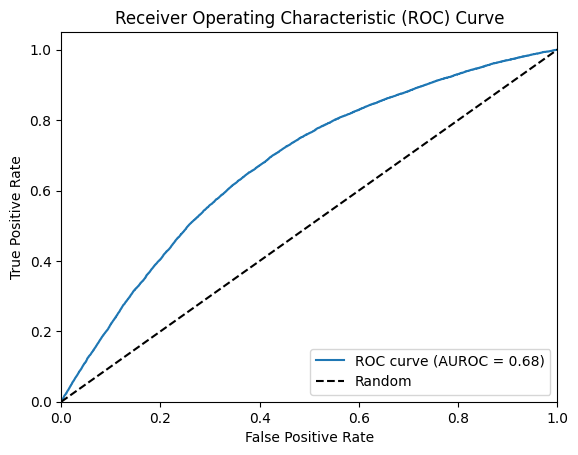

AUROC: 0.6756340748351259
Confusion Matrix:
[[61580   549]
 [15076   334]]
F1-score: 0.040999202111336154


In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, f1_score, make_scorer

# Model selection
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(max_depth=None, max_features=8, n_estimators=100, random_state=123)
clf = DecisionTreeClassifier()

def TrainModel(model):
    global y_pred_proba
    global y_pred

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_train)[:, 1]
    y_pred = model.predict(X_train)

TrainModel(logreg)

# Plot the ROC curve

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# Calculate AUROC score
auroc = roc_auc_score(y_train, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUROC = {:.2f})'.format(auroc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate AUROC score
auroc = roc_auc_score(y_train, y_pred_proba)
print("AUROC:", auroc)

# Calculate a confusion matrix 
cm = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate F1-score
f1 = f1_score(y_train, y_pred)
print("F1-score:", f1)

In [169]:
# To obtain more accurate performance estimates, we should use cross-validation
from sklearn.model_selection import cross_val_score

# Define the scoring metrics
scoring_metrics = {
    'AUROC': 'roc_auc',
    'F1-score': 'f1'
}

# Select the model to validate
model = rf

# Output the performance metrics
for metric_name, metric_func in scoring_metrics.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric_func)
    print(metric_name + ':', scores)
    print('Average ' + metric_name + ':', scores.mean())
    print('')

AUROC: [0.71943353 0.71607363 0.63981283 0.55132382 0.67815814]
Average AUROC: 0.6609603901606546

F1-score: [0.07123616 0.11368653 0.19239862 0.11173554 0.00452928]
Average F1-score: 0.0987172249453703



In [170]:
from sklearn.model_selection import GridSearchCV

# Fine-tune the hyperparameters by using GridSearchCV
# We use F1-score to measure the performance since it's the most appropriate metric in the context of True Positives optimizaiton.
param_grid = [
        {'n_estimators': [100, 200], 'max_features': [8,10], 'max_depth': [None]}
]

grid_search = GridSearchCV(rf, param_grid, cv=5,
                               scoring=make_scorer(f1_score),
                               return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_features=8),
             param_grid=[{'max_depth': [None], 'max_features': [8, 10],
                          'n_estimators': [100, 200]}],
             return_train_score=True, scoring=make_scorer(f1_score))

In [171]:
# Output the results of the GridSearchCV
grid_search.best_params_

{'max_depth': None, 'max_features': 8, 'n_estimators': 100}

In [172]:
# Output the results of each iteration of the GridSearchCV
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    if mean_score < 0:
        print("Negative mean score detected.")
    else:
        print(np.sqrt(mean_score), params)


0.32576242991064486 {'max_depth': None, 'max_features': 8, 'n_estimators': 100}
0.31966238433368 {'max_depth': None, 'max_features': 8, 'n_estimators': 200}
0.32508999765494684 {'max_depth': None, 'max_features': 10, 'n_estimators': 100}
0.31586433298351835 {'max_depth': None, 'max_features': 10, 'n_estimators': 200}


### (10) Analyze the Best Models and Their Errors

We will often gain good insights on the problem by inspecting the best models. For example, the RandomForestClassifier can indicate the relative importance of each attribute for making accurate predictions

In [178]:
# Store the model inside a variable
rf_allvar = grid_search.best_estimator_

# Output the performance of each variable
feature_importance = rf_allvar.feature_importances_
feature_importance

array([2.96110260e-02, 1.84827830e-01, 1.04879709e-02, 1.80611317e-02,
       1.55994726e-02, 1.69153539e-01, 4.58619653e-02, 1.16741734e-02,
       7.83589806e-02, 5.89255049e-02, 1.07189962e-01, 1.33023385e-02,
       7.40111583e-06, 5.43592976e-03, 1.13574677e-03, 1.27572695e-03,
       1.67408527e-03, 4.54783569e-03, 3.10591331e-03, 1.35315866e-03,
       6.28430925e-03, 5.00588629e-03, 6.82916890e-03, 1.10682497e-03,
       2.82130498e-03, 3.67653166e-03, 4.08306074e-03, 5.33572153e-03,
       1.08068390e-03, 1.86539208e-03, 1.61538702e-03, 2.56183891e-03,
       1.13550193e-03, 2.19821334e-03, 2.37564234e-03, 4.63274782e-03,
       1.13084394e-03, 2.43403141e-03, 3.63902297e-03, 4.67185755e-03,
       9.01694685e-04, 3.32745194e-03, 4.61702783e-03, 1.52554762e-04,
       9.01876378e-05, 4.93582083e-03, 9.34296156e-05, 3.14920914e-03,
       5.72771672e-03, 5.05476414e-03, 8.76850025e-03, 5.61854333e-03,
       4.66804396e-03, 3.80888179e-03, 2.29711039e-03, 8.11883597e-03,
      

In [179]:
# Create a list of attributes that were added
extra_attributes = ['LeadTime', 'WeekdayOfApp', 'MonthOfApp', 'DayOfApp', 'WeekdayOfSchedule', 'HourOfSchedule', 'Diagnosis']

# Output a list of numeric attributes that came from the initial dataset
num_attributes

# Output a list of categorical attributes that were obtained using OneHotEncoder class
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attributes = list(cat_encoder.categories_[0])

# Create a list of all attributes in the model
attributes = num_attributes + extra_attributes + cat_one_hot_attributes

sorted(zip(feature_importance, attributes), reverse=True)

[(0.18482782977786807, 'Gender'),
 (0.16915353884337145, 'Scholarship'),
 (0.10718996249276701, 'SMS_received'),
 (0.07835898055532108, 'Alcoholism'),
 (0.058925504936911254, 'Handcap'),
 (0.04586196531627654, 'Hipertension'),
 (0.029611026016037722, 'PatientId'),
 (0.018061131701787997, 'AppointmentDay'),
 (0.01559947263887238, 'Age'),
 (0.013302338492706877, 'Past_No_shows'),
 (0.011674173423175768, 'Diabetes'),
 (0.010487970872641503, 'ScheduledDay'),
 (0.008768500249981447, 'ILHA DO BOI'),
 (0.00811883596577331, 'ITARARÉ'),
 (0.007659332890060123, 'PARQUE MOSCOSO'),
 (0.006829168898228469, 'ARIOVALDO FAVALESSA'),
 (0.006284309253900233, 'ANDORINHAS'),
 (0.006269505519492887, 'SANTOS REIS'),
 (0.005727716721907374, 'ILHA DAS CAIEIRAS'),
 (0.005618543332155115, 'ILHA DO FRADE'),
 (0.005606922840276623, 'SANTOS DUMONT'),
 (0.005593182189032808, 'SANTA CECÍLIA'),
 (0.005435929759802057, 'WeekdayOfApp'),
 (0.005335721528466938, 'BONFIM'),
 (0.005156187156629405, 'PIEDADE'),
 (0.00509270

In [181]:
import joblib

# Save the model to a file so that we don't have to retrain it
joblib.dump(rf_allvar, 'models/rf_allvar.pkl')

['models/rf_allvar.pkl']

Update your feature selection and increase the performance of your model. Since all the categories of the geographic location seem to be impertinent to the model's predictive capabilities, we will try to remove them and train our model again.

In [128]:
# Transformation pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Creating a list of numeric and alpha-numeric attributes for each step of the Pipeline
num_attributes = train_set.drop(["AppointmentID","Neighbourhood"], axis=1)

# Creating a transformation Pipeline for numeric attributes
num_pipeline = Pipeline([
    ('formatting', FormatTransformer(date_columns=["ScheduledDay","AppointmentDay"])),
    ('attr_adder', AttributesAdder()),
    ('std_scaler', StandardScaler())
])

X_train = num_pipeline.fit_transform(num_attributes)

len(X_train)

77539

In [132]:
# To obtain more accurate performance estimates, we should use cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

rf = RandomForestClassifier(max_depth=None, n_estimators=100, max_features=8)

# Define the scoring metrics
scoring_metrics = {
    'AUROC': 'roc_auc',
    'F1-score': 'f1'
}

# Select the model to validate
model = rf

# Output the performance metrics
for metric_name, metric_func in scoring_metrics.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=metric_func)
    print(metric_name + ':', scores)
    print('Average ' + metric_name + ':', scores.mean())
    print('')

AUROC: [0.70029952 0.70085081 0.62492677 0.51773655 0.62592397]
Average AUROC: 0.6339475240349071

F1-score: [0.12005457 0.18820755 0.34434898 0.09988269 0.02609803]
Average F1-score: 0.1557183615653681



In [133]:
from sklearn.model_selection import GridSearchCV

# Fine-tune the hyperparameters by using GridSearchCV
# We use F1-score to measure the performance since it's the most appropriate metric in the context of True Positives optimizaiton.
param_grid = [
        {'n_estimators': [100, 200], 'max_features': [8,10], 'max_depth': [None]}
]

grid_search = GridSearchCV(rf, param_grid, cv=5,
                               scoring=make_scorer(f1_score),
                               return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_features=8),
             param_grid=[{'max_depth': [None], 'max_features': [8, 10],
                          'n_estimators': [100, 200]}],
             return_train_score=True, scoring=make_scorer(f1_score))

In [134]:
grid_search.best_params_

{'max_depth': None, 'max_features': 10, 'n_estimators': 100}

In [135]:
# Output the results of each iteration of the GridSearchCV
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    if mean_score < 0:
        print("Negative mean score detected.")
    else:
        print(np.sqrt(mean_score), params)

0.3971936708421758 {'max_depth': None, 'max_features': 8, 'n_estimators': 100}
0.3953383848561396 {'max_depth': None, 'max_features': 8, 'n_estimators': 200}
0.40243075937592704 {'max_depth': None, 'max_features': 10, 'n_estimators': 100}
0.4007900905159635 {'max_depth': None, 'max_features': 10, 'n_estimators': 200}


In [137]:
# Output the performance of each variable
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([0.0420078 , 0.26603463, 0.02134533, 0.01336554, 0.01979485,
       0.20784015, 0.0510205 , 0.01514761, 0.11011941, 0.07065182,
       0.1570501 , 0.02562227])

In [143]:
# Create a list of attributes that were added
extra_attributes = ['LeadTime', 'WeekdayOfApp', 'MonthOfApp', 'DayOfApp', 'WeekdayOfSchedule', 'HourOfSchedule']

# Output a list of numeric attributes that came from the initial dataset
num_attributes

# Create a list of all attributes in the model
attributes = list(num_attributes) + extra_attributes

sorted(zip(feature_importance, attributes), reverse=True)


[(0.2660346310639115, 'Gender'),
 (0.20784014539839574, 'Scholarship'),
 (0.15705010472764272, 'SMS_received'),
 (0.11011940691494485, 'Alcoholism'),
 (0.07065182400726276, 'Handcap'),
 (0.051020495534006644, 'Hipertension'),
 (0.04200779696283195, 'PatientId'),
 (0.025622270578871717, 'Past_No_shows'),
 (0.02134532723927289, 'ScheduledDay'),
 (0.0197948531562223, 'Age'),
 (0.015147608444168719, 'Diabetes'),
 (0.01336553597246801, 'AppointmentDay')]

After tweaking the attributes and removing the categorical attributes, we see that the model with more attributes seems to perform better. We will keep it without further analysis.

### (11) Evaluate Your System on the Test Set

After tweaking our models for a while, we eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. 

In [184]:
# Load the model from the file
final_model = joblib.load('models/rf_allvar.pkl')

RandomForestClassifier(max_features=8)

In [219]:
# Preprocessing steps for the test set

# Drop duplicates based on 'PatientId' and 'AppointmentDay'
test_set_nodup = strat_test_set.drop_duplicates(subset=['PatientId', 'AppointmentDay'], keep=False)

# Changing No-show formats
test_set_nodup['No-show'].replace({"Yes":1, "No":0}, inplace=True)

# Create variable of previous no-shows
test_set_nodup.sort_values(by=['AppointmentDay','PatientId'],inplace=True)
test_set_nodup['PatientId'] = test_set_nodup['PatientId'].astype(int)

test_set_nodup['Past_No_shows'] = test_set_nodup.groupby('PatientId')['No-show'].cumsum()
test_set_nodup['Past_No_shows'] = test_set_nodup['Past_No_shows'] - test_set_nodup['No-show']

# Separating the predictive variables and the label variable
test_set = test_set_nodup.drop('No-show', axis=1)
y_test = test_set_nodup['No-show']

X_test = full_pipeline.transform(test_set)

X_test

/var/folders/5c/s5mcxltd5tl3kzp0vbb_0vlw0000gn/T/ipykernel_87701/2583359914.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_nodup['No-show'].replace({"Yes":1, "No":0}, inplace=True)
/var/folders/5c/s5mcxltd5tl3kzp0vbb_0vlw0000gn/T/ipykernel_87701/2583359914.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_nodup.sort_values(by=['AppointmentDay','PatientId'],inplace=True)
/var/folders/5c/s5mcxltd5tl3kzp0vbb_0vlw0000gn/T/ipykernel_87701/2583359914.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

<21291x93 sparse matrix of type '<class 'numpy.float64'>'
	with 276783 stored elements in Compressed Sparse Row format>

In [220]:
# Predict values for our test set
final_predictions = final_model.predict(X_test)

In [222]:
# Measure the results of our model on the test set

# Calculate a confusion matrix 
cm = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(cm)

# Calculate F1-score
f1 = f1_score(y_test, final_predictions)
print("F1-score:", f1)

Confusion Matrix:
[[16494   501]
 [ 3752   544]]
F1-score: 0.2037071709417712


Now comes the project prelaunch phase: we need to present our solution (high‐ lighting what we have learned, what worked and what did not, what assumptions were made, and what our system’s limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., “*on saturdays, you should overbook by 18% to compensate for the no-shows*”).

### (12) Launch, Monitor, and Maintain Your System

Once approved, we need to get our solution ready for production, in particular by plugging the production input data sources into our system and writing tests.

We also need to write monitoring code to check our system’s live performance at regular intervals and trigger alerts when it drops. This is important to catch not only sudden breakage, but also performance degradation. This is quite common because models tend to “rot” as data evolves over time, unless the models are regularly trained on fresh data.

Evaluating our system’s performance will require sampling the system’s predictions and evaluating them. This will generally require a human analysis. These analysts may be field experts, or workers on a crowdsourcing platform.

We should also make sure we evaluate the system’s input data quality. Sometimes performance will degrade slightly because of a poor quality signal (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale), but it may take a while before our system’s performance degrades enough to trigger an alert. If we monitor our system’s inputs, we may catch this earlier. Monitoring the inputs is particularly important for online learning systems.

We generally want to train our models on a regular basis using fresh data. We should automate this process as much as possible. If we don’t, we are very likely to refresh our model only every six months (at best), and our system’s performance may fluctuate severely over time. If our system is an online learning system, we should make sure we save snapshots of its state at regular intervals so we can easily roll back to a previously working state.